In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

In [8]:
# append fast.ai local folder to system path so modules can be imported
sys.path.append('/home/paperspace/fastai/')
# automatically reload updated sub-modules
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.structured import *
from fastai.column_data import *

In [9]:
PATH = '~/data/avito-demand-prediction/'

### Data Preparation
Loading and transforming data as required for fast.ai model

In [16]:
df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

In [23]:
# get features from date value
add_datepart(df_train, 'activation_date', drop=False)
add_datepart(df_test, 'activation_date', drop=False)

# select relevant variables
vars_cont = ['price','item_seq_number','deal_probability']
vars_cat = ['region','city','parent_category_name','category_name',
            'user_type','image_top_1','param_1','param_2','param_3',
            'activation_Year','activation_Month','activation_Week',
            'activation_Day','activation_Dayofweek','activation_Dayofyear']
vars_other = ['item_id','user_id','image','title','description']

# only keep these vars for now
df_train = df_train[vars_cat + vars_cont]
for v in vars_cat: df_train[v] = df_train[v].astype('category').cat.as_ordered()
for v in vars_cont: df_train[v] = df_train[v].astype('float32')

# same process on test dataset
df_test = df_test[vars_cat + vars_cont[0:-1]]
for v in vars_cat: df_test[v] = df_test[v].astype('category').cat.as_ordered()
for v in vars_cont[0:1]: df_test[v] = df_test[v].astype('float32')
# in test set, y var needs to be set to zero manually
df_test['deal_probability'] = 0

## combine train and test
#df = pd.concat([df_train, df_test])
## only keep these vars for now
#df = df[vars_cat + vars_cont]

In [17]:
df_train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [18]:
df_test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [24]:
# get cardinality of categorical variables
sz_cat = [(c, len(df_train[c].cat.categories)+1) for c in vars_cat]
# determine suitable embedding matrix sizes
sz_emb = [(c, min(50, (c+1)//2)) for _,c in sz_cat]

In [25]:
# process training data
X, y, nas, mapper = proc_df(df_train, 'deal_probability', do_scale=True)
# same for test data but supply mapper and na_dict from train data
X_test, y_test, nas, mapper = proc_df(df_test, 'deal_probability', do_scale=True, mapper=mapper, na_dict=nas)

In [26]:
# create validation set index
np.random.seed(1234)
val_ratio = 0.25
val_size = int(len(X) * val_ratio)
val_idx = list(np.random.choice(a = range(0, len(X)), size=val_size, replace=False))

In [27]:
# make data generator
md = ColumnarModelData.from_data_frame(
    path=PATH, val_idxs=val_idx, df=X, y=y, cat_flds=vars_cat, bs=128,
    is_reg=True, test_df=X_test)

In [28]:
# create learner
m = md.get_learner(
    emb_szs=sz_emb, n_cont=len(df_train.columns)-len(vars_cat),
    emb_drop=0.04, out_sz=1, szs=[1000,500], drops=[0.001,0.01], y_range=(0,100))

In [29]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 70%|██████▉   | 6134/8810 [01:00<00:26, 102.13it/s, loss=0.309] 

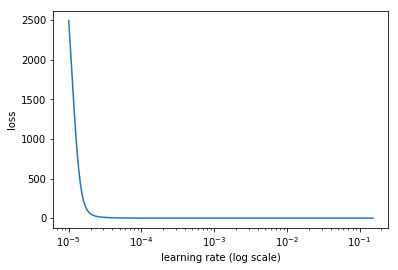

In [30]:
m.sched.plot(n_skip=0, n_skip_end=0)

In [31]:
lr = 0.0002

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# define error term
def rmse(y_pred, targ):
    out = sqrt(mean_squared_error(targ, y_pred))
    return out

In [33]:
m.fit(lrs=lr, n_cycle=3, cycle_len=2, metrics=[rmse])

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

  7%|▋         | 580/8810 [00:04<01:03, 129.48it/s, loss=1.08e+03]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   rmse                             
    0      0.059848   0.060213   0.244896  
    1      0.056595   0.056097   0.236387                        
    2      0.052196   0.053625   0.23108                         
    3      0.054295   0.053807   0.231503                        
    4      0.051397   0.053767   0.23141                         
    5      0.053086   0.05378    0.231444                        



[array([0.05378]), 0.23144380893793248]

In [34]:
# get final RMSE on holdout data
x,y = m.predict_with_targs()
rmse(x,y)

0.23190487332456544

In [36]:
m.save('val03')

In [ ]:
# df_test = pd.read_csv(f'{PATH}test.csv')

### Submission
Produce expected output format and submit to kaggle

In [37]:
pred_test = m.predict(is_test=True)

In [40]:
df_test_original = pd.read_csv(f'{PATH}test.csv')

In [41]:
# produce output
out = pd.DataFrame(
    data={
        'item_id': df_test_original.item_id,
        'deal_probability': pred_test[:,0]})
# reorder columns
out = out[['item_id','deal_probability']]

In [42]:
out.to_csv('~/avito/out/submission003.csv', index=False)

In [43]:
!head ~/avito/out/submission003.csv

item_id,deal_probability
6544e41a8817,0.0714207
65b9484d670f,0.095154785
8bab230b2ecd,0.1202729
8e348601fefc,0.20385525
8bd2fe400b89,0.19951853
c63dbd6c657f,0.10457993
6d1a410df86e,0.0003509268
e8d3e7922b80,0.029179484
2bc1ab208462,0.05914002


In [44]:
!kaggle competitions submit -c avito-demand-prediction -f ~/avito/out/submission003.csv -m ann-second-go-indcluding-dates

Successfully submitted to Avito Demand Prediction Challenge